In [1]:
import arviz as az
import numpy as np
import pymc as pm
from pymc.math import switch, ge
from scipy import stats

# Hypothesis Testing*

## Psoriasis: Two-sample problem with paired data

This is our first example of hypothesis testing.

Adapted from [Unit 6: psoriasis.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit6/psoriasis.odc).

Woo and McKenna (2003) investigated the effect of broadband ultraviolet B (UVB) therapy and topical calcipotriol cream used together on areas of psoriasis. One of the outcome variables is the Psoriasis Area and Severity Index (PASI), where a lower score is better.

The PASI scores for 20 subjects are measured at baseline and after 8 treatments.  Do these data provide sufficient evidence to indicate that the combination therapy reduces PASI scores?

In [2]:
# fmt: off
baseline = np.array((5.9, 7.6, 12.8, 16.5, 6.1, 14.4, 6.6, 5.4, 9.6, 11.6, 
                     11.1, 15.6, 9.6, 15.2, 21.0, 5.9, 10.0, 12.2, 20.2, 
                     6.2))

after = np.array((5.2, 12.2, 4.6, 4.0, 0.4, 3.8, 1.2, 3.1, 3.5, 4.9, 11.1,
                  8.4, 5.8, 5, 6.4, 0.0, 2.7, 5.1, 4.8, 4.2))
# fmt: on

I tried to recreate the classical analysis from the original example, but got slightly different values.

In [3]:
# Classical Analysis

d = baseline - after
n = len(d)
dbar = np.mean(d)
stdev = np.std(d)
tstat = dbar / (stdev / np.sqrt(n))

pval = 2 * (1 - stats.t.cdf(abs(tstat), df=n - 1))

print(f"dbar  = {dbar:.4f}")
print(f"stdev = {stdev:.4f}")
print(f"tstat = {tstat:.4f}")
print(f"pval  = {pval:.8f}")

alpha = 0.05
df = n - 1
tcrit = stats.t.ppf(1 - alpha / 2, df=df)
ci_lower = dbar - tcrit * stdev / np.sqrt(n)
ci_upper = dbar + tcrit * stdev / np.sqrt(n)

print(f"95% CI = [{ci_lower:.4f}, {ci_upper:.4f}]")

dbar  = 6.3550
stdev = 4.8061
tstat = 5.9134
pval  = 0.00001080
95% CI = [4.1057, 8.6043]


In [ ]:
with pm.Model() as m:
    # priors
    mu = pm.Normal("mu", mu=0, sigma=316)
    # prec = pm.Gamma("prec", alpha=0.001, beta=0.001) # From the lecture version
    # sigma = pm.Deterministic("sigma", 1 / pm.math.sqrt(prec))

    sigma = pm.Exponential("sigma", 0.05)

    ph1 = pm.Deterministic("ph1", switch(mu >= 0, 1, 0))

    pm.Normal("diff", mu=mu, sigma=sigma, observed=baseline - after)

    trace = pm.sample(5000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1 seconds.


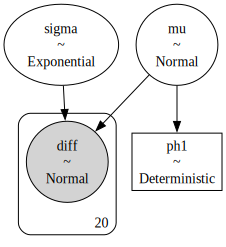

In [5]:
pm.model_to_graphviz(m)

In [6]:
az.summary(trace, hdi_prob=0.95)

/Users/aaron/miniforge3/envs/pymc_macos15/lib/python3.12/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,6.359,1.193,4.004,8.704,0.009,0.007,16048.0,12442.0,1.0
sigma,5.244,0.916,3.686,7.137,0.008,0.006,14145.0,12706.0,1.0
ph1,1.000,0.000,1.000,1.000,0.000,0.000,20000.0,20000.0,NaN


Our model agrees with the BUGS results:

|          | mean     | sd      | MC_error | val2.5pc | median | val97.5pc | start | sample |
|----------|----------|---------|----------|----------|--------|-----------|-------|--------|
| pH1      | 1        | 0       | 3.16E-13 | 1        | 1      | 1         | 1001  | 100000 |
| mu       | 6.352    | 1.169   | 0.003657 | 4.043    | 6.351  | 8.666     | 1001  | 100000 |
| sigma    | 5.142    | 0.8912  | 0.003126 | 3.74     | 5.026  | 7.203     | 1001  | 100000 |
| pval     | 4.20E-04 | 0.02049 | 6.04E-05 | 0        | 0      | 0         | 1001  | 100000 |

## Equivalence of generic and brand-name drugs

Adapted from [Unit 6: equivalence.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit6/equivalence.odc).

The manufacturer wishes to demonstrate that their generic drug for a particular metabolic disorder is equivalent to a brand name drug. One of indication of the disorder is an abnormally low concentration of levocarnitine, an amino acid derivative, in the plasma. The treatment with the brand name drug substantially increases this concentration.

A small clinical trial is conducted with 43 patients, 18 in the Brand Name Drug arm and 25 in the Generic Drug arm. The increases in the log-concentration of levocarnitine are in the data below.

The FDA declares that bioequivalence among the two drugs can be established if the difference in response to the two drugs is within 2 units of log-concentration. Assuming that the log-concentration measurements follow normal distributions with equal population variance, can these two drugs be declared bioequivalent within a tolerance +/-2  units?

---
The way the data is set up in the .odc file is strange. It seems simpler to just have a separate list for each increase type.

In [7]:
# fmt: off
increase_type1 = [7, 8, 4, 6, 10, 10, 5, 7, 9, 8, 6, 7, 8, 4, 6, 10, 8, 9]
increase_type2 = [6, 7, 5, 9, 5, 5, 3, 7, 5, 10, 8, 5, 8, 4, 4, 8, 6, 11, 
                  7, 5, 5, 5, 7, 4, 6]
# fmt: on

We're using ```pm.math.switch``` and ```pm.math.eq``` to recreate the BUGS ```step()``` function for the ```probint``` variable.

In [8]:
with pm.Model() as m:
    # priors
    mu1 = pm.Normal("mu1", mu=10, sigma=316)
    mu2 = pm.Normal("mu2", mu=10, sigma=316)
    mudiff = pm.Deterministic("mudiff", mu1 - mu2)
    prec = pm.Gamma("prec", alpha=0.001, beta=0.001)
    sigma = 1 / pm.math.sqrt(
        prec
    )  # lecture example. could also put prior on sigma directly

    probint = pm.Deterministic(
        "probint",
        switch(ge(mudiff + 2, 0), 1, 0) * switch(ge(2 - mudiff, 0), 1, 0),
    )

    pm.Normal("y_type1", mu=mu1, sigma=sigma, observed=increase_type1)
    pm.Normal("y_type2", mu=mu2, sigma=sigma, observed=increase_type2)

    trace = pm.sample(5000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu1, mu2, prec]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 1 seconds.


In [9]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu1,7.329,0.475,6.417,8.275,0.003,0.002,28401.0,15725.0,1.0
mu2,6.200,0.395,5.424,6.979,0.002,0.002,25971.0,16229.0,1.0
prec,0.263,0.058,0.157,0.380,0.000,0.000,23926.0,14853.0,1.0
mudiff,1.129,0.610,-0.042,2.345,0.004,0.003,27559.0,15641.0,1.0
probint,0.927,0.260,0.000,1.000,0.002,0.001,16634.0,16634.0,1.0


BUGS results:

|          | mean   | sd      | MC_error | val2.5pc | median | val97.5pc | start | sample |
|----------|--------|---------|----------|----------|--------|-----------|-------|--------|
| mu[1]    | 7.332  | 0.473   | 0.001469 | 6.399    | 7.332  | 8.264     | 1001  | 100000 |
| mu[2]    | 6.198  | 0.4006  | 0.001213 | 5.406    | 6.199  | 6.985     | 1001  | 100000 |
| mudiff   | 1.133  | 0.618   | 0.00196  | -0.07884 | 1.134  | 2.354     | 1001  | 100000 |
| prec     | 0.2626 | 0.05792 | 1.90E-04 | 0.1617   | 0.2584 | 0.3877    | 1001  | 100000 |
| probint  | 0.9209 | 0.2699  | 9.07E-04 | 0        | 1      | 1         | 1001  | 100000 |

In [10]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor

Last updated: Sat Mar 08 2025

Python implementation: CPython
Python version       : 3.12.7
IPython version      : 8.29.0

pytensor: 2.26.4

pymc : 5.19.1
scipy: 1.14.1
arviz: 0.20.0
numpy: 1.26.4

